[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

グラフ状態のスキーマとレデューサーのカスタマイズ方法について説明しました。

また、グラフステート内のメッセージのトリミングやフィルタリング方法も紹介しました。

これらのコンセプトを、会話の要約を生成するメモリ付きのチャットボットに使いました。

## Goals

しかし、もしチャットボットに無期限のメモリを持たせたいとしたらどうでしょうか？

ここでは、外部データベースをサポートする、より高度なcheckpointerを紹介します。

ここでは、[checkpointerとしてSqlite](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer) を使用する方法を紹介しますが、[Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) もcheckpointerとして利用可能です！


In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## Sqlite

If we supply `":memory:"` it creates an in-memory Sqlite database.

ここでの良い出発点は[SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)です。

Sqliteは[small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQLデータベースです。

`":memory:"`を指定すると、インメモリのSqliteデータベースを作成します。

In [2]:
import sqlite3

# In memory
conn = sqlite3.connect(":memory:", check_same_thread=False)

しかし、DBのPathを指定すると、データベースを作成してくれます！

In [3]:
# ローカルのDBファイル(./module-2/state_db/example.db)が無いときは、下記のコマンドで取得して下さい。
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

# この chatbot-external-memory.ipynb からみた相対パス
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (ja_JP.UTF-8)


In [4]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

チャットボットを再度定義しましょう。

In [5]:
from typing import Any, Literal
from langchain_core.messages.base import BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0)


class State(MessagesState):
    summary: str


# モデルを呼び出すロジックを定義
def call_model(state: State) -> dict[str, BaseMessage]:
    # 要約があれば取得する
    summary = state.get("summary", "")

    # 要約があれば、それに追加する
    if summary:
        # system message に要約を追加する
        system_message = f"これまでの会話の要約: {summary}"

        # 新しい message に要約を追加する
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}


def summarize_conversation(state: State) -> dict[str, Any]:
    # 最初に, 既存の要約を取得
    summary = state.get("summary", "")

    # 要約するためのプロンプトを作成する
    if summary:
        # 要約がすでにある場合
        summary_message = (
            f"これは今までの会話の要約です: {summary}\n\n" + "上の新しいメッセージを考慮して、要約を拡張します:"
        )

    else:
        summary_message = "上記の会話を要約してください:"

    # 履歴にプロンプトを追加する
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 直近2つのメッセージ以外は削除する
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# 会話を終了するか要約するかを決定
def should_continue(state: State) -> Literal["summarize_conversation"] | Literal["__end__"]:
    """次に実行するnodeを返却します"""

    messages = state["messages"]

    # メッセージが6つより多い場合は、会話を要約します
    if len(messages) > 6:
        return "summarize_conversation"

    # そうでなければ終了
    return END

あとはsqlite checkpointerを使って再コンパイルするだけです。


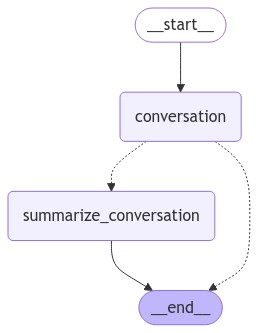

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

これで、グラフを何度も呼び出すことができるようになりました。

In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="こんにちは! ランスです。")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="私の名前は?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="49ersが好きです!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

こんにちは、ランスさん！またお会いできて嬉しいです。49ersについてもっと話したいですか？それとも、他に興味のあるトピックがありますか？お気軽に教えてくださいね。
================================== Ai Message ==================================

あなたの名前はランスさんです。何か他にお手伝いできることがあれば教えてください！
================================== Ai Message ==================================

49ersが好きなんですね！素晴らしいです。49ersのどんなところが好きですか？選手、試合、歴史など、どんなことでもお話ししましょう。


状態がローカルに保存されていることを確認しましょう。


In [8]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='こんにちは! ランスです。', additional_kwargs={}, response_metadata={}, id='b5283fea-3ed9-4bc8-9516-a00027d84b48'), AIMessage(content='こんにちは、ランスさん！またお会いできて嬉しいです。49ersについてもっと話したいですか？それとも、他に興味のあるトピックがありますか？お気軽に教えてくださいね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 343, 'total_tokens': 392, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'stop', 'logprobs': None}, id='run-1a4d7ed2-9349-4584-b936-6675f4846332-0', usage_metadata={'input_tokens': 343, 'output_tokens': 49, 'total_tokens': 392}), HumanMessage(content='私の名前は?', additional_kwargs={}, response_metadata={}, id='53164f68-53d0-4444-bfa8-27c8fd5d3268'), AIMessage(content='あなたの名前はランスさんです。何か他にお手伝いできることがあれば教えてください！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens

### 状態(state)を永続化(Persist)する

Sqliteのようなデータベースを使うと、状態が永続化されます！

例えば、ノートブック・カーネルを再起動し、ディスク上のSqlite DBからロードできることを確認できます。



In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='こんにちは! ランスです。', additional_kwargs={}, response_metadata={}, id='b5283fea-3ed9-4bc8-9516-a00027d84b48'), AIMessage(content='こんにちは、ランスさん！またお会いできて嬉しいです。49ersについてもっと話したいですか？それとも、他に興味のあるトピックがありますか？お気軽に教えてくださいね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 343, 'total_tokens': 392, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'stop', 'logprobs': None}, id='run-1a4d7ed2-9349-4584-b936-6675f4846332-0', usage_metadata={'input_tokens': 343, 'output_tokens': 49, 'total_tokens': 392}), HumanMessage(content='私の名前は?', additional_kwargs={}, response_metadata={}, id='53164f68-53d0-4444-bfa8-27c8fd5d3268'), AIMessage(content='あなたの名前はランスさんです。何か他にお手伝いできることがあれば教えてください！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*現状、LangGraph Studioの実行にはMacが必要です。* 無いなら、このステップはスキップしてください。

--

さて、外部メモリについて理解を深めたところで、LangGraph APIがあなたのコードをパッケージ化し、ビルトインの永続性(実装はPostgres)を提供していることを覚えておいてください。

そしてAPIはLangGraph Studioのバックエンドです！

`module-2/studio/langgraph.json`に設定された`module2-/studio/chatbot.py`を使用します。
